# Exploratory Data Analysis and Proof of Concept
 
## Introduction

This notebook presents an Exploratory Data Analysis (EDA) on air quality data for the city of Medellin, Colombia, using data sourced from [OpenAQ](https://openaq.org/). The primary objective is to investigate the feasibility of replacing a specific air quality sensor with a machine learning (ML) model. This model will predict the sensor's readings based on data from nearby sensors, serving as a backup or cost-effective replacement. 

The analysis will guide the selection of a sensor location for the ML model proof of concept, ultimately aiding in the mapping of air quality across the city.

### Importing Necessary Libraries

We begin by importing the essential libraries for our analysis:

In [1]:
# Data Retrieval and Handling
import requests
import os
import pandas as pd

# Data Visualization
import folium
import matplotlib.pyplot as plt

# Time and Date Manipulation
import time
from datetime import datetime, timezone, timedelta
from dateutil.relativedelta import relativedelta

# Progress Tracking
from tqdm import tqdm

# Utility Functions and Miscellaneous
import urllib.parse
from haversine import haversine, Unit
import numpy as np
from scipy import stats
from functools import reduce

# Machine Learning
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error

# Data Preprocessing and Dimensionality Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Hyperparameter Optimization
import optuna

## Data Retrieval

To begin our analysis, we first need to gather the air quality data for Medellin. There are two main sources we considered:

1. **[The Amazon Sustainability Data Initiative (ASDI)](https://aws.amazon.com/marketplace/seller-profile?id=e40a6e9c-c840-413d-a235-0a5e458ae0c0)**, which provides access to datasets, including OpenAQ data, via an AWS S3 bucket. You can explore the [OpenAQ resource](https://aws.amazon.com/marketplace/pp/prodview-rvesvhymasphs#resources) for more details.
2. **[OpenAQ API](https://docs.openaq.org/docs/introduction)**, which offers a direct way to access air quality data through API calls.

After evaluating these options, I chose the OpenAQ API for the following reasons:

- **Completeness**: The data available via the AWS S3 bucket was found to be incomplete for our purposes.
- **Real-time Simulation**: Using the OpenAQ API aligns better with our goal of simulating a real-world scenario. In such a scenario, data from nearby sensors would be fetched in real-time to predict values for the sensor we're aiming to replace.

This setup will provide a smoother transition to a production environment, where the model can continuously receive fresh data and make predictions.

We will now proceed with fetching the data using the OpenAQ API.

### API Key

To access the OpenAQ API at the full rate limit, an API key is required starting from July 1, 2023. Key-less access is still available, but at a significantly lower rate limit. This API key can be obtained for free by registering on the OpenAQ platform.

You can register for an API Key at [OpenAQ Registration](https://explore.openaq.org/register). Once registered with a valid email address, you can access your API key by signing in and visiting your account settings at [OpenAQ Explorer Account Settings](https://explore.openaq.org/account).

In [2]:
headers = {"accept": "application/json", "X-API-Key": os.environ['OPENAQ_API_KEY']}
base_url = "https://api.openaq.org/v3/"

### Retrieving Sensor Locations

To begin our data collection, we need to identify the available air quality sensors in the vicinity of Medellin. We do this by specifying the latitude and longitude of a central point in the city, along with a radius of 15km to define the area of interest. We use these parameters to query the OpenAQ API for sensor locations within this area.

In [3]:
mde_latitude = 6.243
mde_longitude = -75.575
radius = 15000  # meters
url = base_url + f"locations?&coordinates={mde_latitude}%2C{mde_longitude}&radius={radius}"

response = requests.get(url, headers=headers)

locations = []
for location in response.json()["results"]:
    locations.append(location["id"])

print(f"There are {len(locations)} locations in this area.")

There are 20 locations in this area.


Let's inspect one location in detail:

In [4]:
response.json()['results'][0]

{'id': 6396,
 'name': 'ITA-POGO - Itagüí - Estación de Policía Los Gómez',
 'locality': 'Itagüí',
 'timezone': 'America/Bogota',
 'country': {'id': 138, 'code': 'CO', 'name': 'Colombia'},
 'owner': {'id': 4, 'name': 'Unknown Governmental Organization'},
 'provider': {'id': 206, 'name': 'Medellin'},
 'isMobile': False,
 'isMonitor': True,
 'instruments': [{'id': 2, 'name': 'Government Monitor'}],
 'sensors': [{'id': 5079414,
   'name': 'pm10 µg/m³',
   'parameter': {'id': 1,
    'name': 'pm10',
    'units': 'µg/m³',
    'displayName': 'PM10'}}],
 'coordinates': {'latitude': 6.189889, 'longitude': -75.610611},
 'licenses': None,
 'bounds': [-75.610611, 6.189889, -75.610611, 6.189889],
 'distance': 7073.09486689,
 'datetimeFirst': {'utc': '2024-06-13T13:00:00+00:00',
  'local': '2024-06-13T08:00:00-05:00'},
 'datetimeLast': {'utc': '2024-07-25T14:00:00+00:00',
  'local': '2024-07-25T09:00:00-05:00'}}

### Extracting and Structuring Location and Sensor Data

After retrieving the sensor locations from the OpenAQ API, we proceed to extract detailed information about each location and its associated sensors. This data will be structured into a more manageable format for further analysis.

#### Functions for Data Extraction

Two functions are defined to handle the data extraction:

1. **`extract_location_data(location_data)`**:
   This function takes a dictionary representing a location's data and extracts relevant fields such as location ID, name, locality, timezone, country information, owner and provider details, mobility status, and geographical coordinates. Additionally, it captures the first and last recorded data timestamps in UTC.

2. **`extract_sensors(location_data)`**:
   This function extracts sensor-specific information for each location. It iterates over the list of sensors associated with a location and gathers details like the sensor ID, name, and associated parameters (including their units and display names).

#### Processing the Data

We then loop through each location in the API response, extracting the location data and sensors data using the defined functions. The extracted data is stored in separate lists, which are later converted into Pandas DataFrames for ease of manipulation and analysis.

In [5]:
def extract_location_data(location_data):
    data_dict = {
        "id": location_data["id"],
        "name": location_data["name"],
        "locality": location_data.get("locality"),
        "timezone": location_data["timezone"],
        "country_id": location_data["country"]["id"],
        "country_code": location_data["country"]["code"],
        "country_name": location_data["country"]["name"],
        "owner_id": location_data["owner"]["id"],
        "owner_name": location_data["owner"]["name"],
        "provider_id": location_data["provider"]["id"],
        "provider_name": location_data["provider"]["name"],
        "isMobile": location_data["isMobile"],
        "isMonitor": location_data["isMonitor"],
        "latitude": location_data["coordinates"]["latitude"],
        "longitude": location_data["coordinates"]["longitude"],
        "datetimeFirst_utc": location_data["datetimeFirst"]["utc"],
        "datetimeLast_utc": location_data["datetimeLast"]["utc"],
    }
    return data_dict


def extract_sensors(location_data):
    sensors = []
    for sensor in location_data.get("sensors", []):
        sensors.append(
            {
                "location_id": location_data["id"],
                "sensor_id": sensor["id"],
                "sensor_name": sensor["name"],
                "parameter_id": sensor["parameter"]["id"],
                "parameter_name": sensor["parameter"]["name"],
                "parameter_units": sensor["parameter"]["units"],
                "parameter_displayName": sensor["parameter"]["displayName"],
            }
        )
    return sensors


location_data = []
sensors_data = []

for location in response.json()["results"]:

    location_data.append(extract_location_data(location))
    sensors_data.extend(extract_sensors(location))

df_locations = pd.DataFrame(location_data)
df_sensors = pd.DataFrame(sensors_data)

In [6]:
df_sensors.head()

,location_id,sensor_id,sensor_name,parameter_id,parameter_name,parameter_units,parameter_displayName
0,6396,5079414,pm10 µg/m³,1,pm10,µg/m³,PM10
1,7061,20466,pm25 µg/m³,2,pm25,µg/m³,PM2.5
2,7063,20468,pm25 µg/m³,2,pm25,µg/m³,PM2.5
3,7067,20476,pm25 µg/m³,2,pm25,µg/m³,PM2.5
4,10500,34836,o3 ppm,10,o3,ppm,O₃


### Visualizing Sensor Locations on a Map

To understand the geographical distribution of air quality sensors in Medellin, we use the `folium` library to create an interactive map. This visualization provides a clear view of sensor placements, helping us identify areas with high sensor density or potential coverage gaps.

We start by centering the map on Medellin using specific latitude and longitude coordinates. A suitable zoom level is set to ensure all sensors are visible within the city's area. Next, we iterate through the dataset of sensor locations, adding markers for each sensor on the map. These markers include popups that display the unique ID of each sensor, facilitating easy identification.

In [7]:
mde_center = [mde_latitude, mde_longitude]
zoom_level = 12

# Create a folium map centered around the specific location
map = folium.Map(location=mde_center, zoom_start=zoom_level)

# Add points to the map with popups showing the ID
for idx, row in df_locations.iterrows():
    folium.Marker([row["latitude"], row["longitude"]], popup=f"ID: {row['id']}").add_to(
        map
    )

map.save("./img/maps/sensor_locations.html")

map

![](./img/sensor_locations.png)

In [8]:
df_sensors.head()

,location_id,sensor_id,sensor_name,parameter_id,parameter_name,parameter_units,parameter_displayName
0,6396,5079414,pm10 µg/m³,1,pm10,µg/m³,PM10
1,7061,20466,pm25 µg/m³,2,pm25,µg/m³,PM2.5
2,7063,20468,pm25 µg/m³,2,pm25,µg/m³,PM2.5
3,7067,20476,pm25 µg/m³,2,pm25,µg/m³,PM2.5
4,10500,34836,o3 ppm,10,o3,ppm,O₃


### Fetching Sensor Measurement Data

In this section, we gather historical measurement data from each sensor identified earlier.

#### Defining the Date Range

We set a date range from January 1, 2022, to June 30, 2024, in UTC time, to ensure consistent time zone handling across all data points.

#### URL Generation Function

The `generate_url` function constructs the API request URL for fetching sensor measurements. It uses the sensor ID, start and end dates, and sets the period to hourly data points (`period_name="hour"`). This function encodes the parameters and returns the full URL for API requests.

#### Data Fetching Function

The `fetch_sensor_data` function retrieves data for each sensor within the specified date range. It:
1. Iterates over each month within the date range.
2. For each month, constructs the API request URL using the `generate_url` function.
3. Handles possible API response codes, including rate limits and errors, by implementing delays or retries.
4. Extracts the sensor data, including the timestamp (`datetime`) and measurement value (`value`), and appends it to the `sensor_data` list.

#### Data Collection

We loop through each sensor ID, fetch the corresponding data, and compile all results into a single list, `all_data`. This list is then converted into a Pandas DataFrame for further analysis and saved as a CSV file (`sensor_data.csv`) for persistent storage. (This is done to avoid waiting a second time for this data in case you want to continue the analysis in a later time).

This step ensures we have a comprehensive dataset covering various sensors and time periods, allowing for detailed exploratory data analysis and model training.

In [9]:
sensor_ids = df_sensors.sensor_id.to_list()

start_date = datetime(2022, 1, 1, tzinfo=timezone.utc)
end_date = datetime(2024, 6, 30, tzinfo=timezone.utc)


def generate_url(sensor_id, start, end, limit=1000):
    base_url = f"https://api.openaq.org/v3/sensors/{sensor_id}/measurements"

    params = {
        "period_name": "hour",
        "date_from": start.isoformat(),
        "date_to": end.isoformat(),
        "limit": limit,
        "page": "1",
    }
    encoded_params = urllib.parse.urlencode(params)

    full_url = f"{base_url}?{encoded_params}"

    return full_url


all_data = []


def fetch_sensor_data(sensor_id):
    sensor_data = []

    date_range = pd.date_range(start_date, end_date, freq="MS")

    for current_date in tqdm(date_range, desc=f"{sensor_id:>10}"):
        month_end = current_date + relativedelta(months=1)

        while True:
            url = generate_url(sensor_id, current_date, month_end)
            response = requests.get(url, headers=headers)
            # print(url)

            if response.status_code == 429:
                #print("Rate limit exceeded, sleeping for 30 seconds...")
                time.sleep(30)
                continue

            if response.status_code == 403:
                #print("Error 403", sensor_id)
                time.sleep(30)
                continue

            if response.status_code == 408:
                #print("Error 408", sensor_id)
                time.sleep(30)
                continue

            if response.status_code != 200:
                print(f"Error: {response.status_code}")
                print(url)
                break

            data = response.json()
            if not data["results"]:
                break

            for item in data["results"]:
                value = item["value"]
                utc_datetime = item["period"]["datetimeFrom"]["utc"]
                sensor_data.append(
                    {"sensor_id": sensor_id, "datetime": utc_datetime, "value": value}
                )
            break

    return sensor_data


# Iterate over all sensors and fetch data
for sensor_id in sensor_ids:
    sensor_data = fetch_sensor_data(sensor_id)
    all_data.extend(sensor_data)

df = pd.DataFrame(all_data)

df.to_csv("sensor_data.csv", index=False)

     36092: 100%|██████████| 30/30 [00:53<00:00,  1.77s/it]


## Data Cleaning and Visualization

### Sanity Check: Removing Sensors Without Data

To ensure the quality and relevance of our dataset, we perform a sanity check to identify and remove any sensors that do not have associated measurement data. This step is crucial because it helps to avoid including sensors that were either inactive or failed to record data during the specified period.

In [10]:
empty_measurements = []
for sensor_id in sensor_ids:
    if all(~(df['sensor_id'] == sensor_id)):
        empty_measurements.append(sensor_id)

df_sensors = df_sensors[~df_sensors['sensor_id'].isin(empty_measurements)]
df_sensors.reset_index(inplace=True,drop=True)

df_locations = df_locations[df_locations['id'].isin(set(df_sensors['location_id']))]
df_locations.reset_index(inplace=True, drop=True)

To facilitate analysis, we pivot the dataset. The resulting `pivot_df` provides a time-series view of measurements, simplifying further analysis and modeling.

In [11]:
pivot_df = df.pivot(index='datetime', columns='sensor_id', values='value').reset_index()
pivot_df = pivot_df.rename_axis(None, axis=1)
pivot_df.columns = [f'sid_{col}' if isinstance(col, int) else col for col in pivot_df.columns[:]]
pivot_df.tail()

,datetime,sid_20466,sid_20468,sid_20476,sid_34834,sid_34835,sid_34836,sid_34841,sid_34845,sid_34997,...,sid_35609,sid_35624,sid_35843,sid_36009,sid_36047,sid_36064,sid_36066,sid_36092,sid_5079414,sid_5079565
16671,2024-06-30T19:00:00+00:00,12.0,13.0,9.7,12.0,NaN,0.029,7.0,0.00045,NaN,...,1.40,0.044,32.0,13.0,12.0,18.0,28.0,NaN,NaN,15.0
16672,2024-06-30T20:00:00+00:00,2.5,11.0,9.7,7.0,10.0,0.032,9.0,NaN,11.0,...,1.20,0.029,17.0,12.0,NaN,20.0,32.0,13.0,NaN,2.5
16673,2024-06-30T21:00:00+00:00,17.0,13.0,11.0,6.0,13.0,0.027,11.0,0.00210,NaN,...,0.98,0.028,29.0,10.0,NaN,4.0,12.0,NaN,NaN,11.0
16674,2024-06-30T22:00:00+00:00,NaN,NaN,0.5,7.0,10.0,0.024,10.0,0.00590,9.7,...,0.71,0.019,NaN,6.0,1.2,9.0,17.0,NaN,NaN,NaN
16675,2024-06-30T23:00:00+00:00,6.0,5.8,NaN,8.0,NaN,0.014,8.0,NaN,NaN,...,1.10,0.011,NaN,5.0,2.4,21.0,NaN,3.5,NaN,4.7


### Ensuring Complete Time Series: Filling Missing Timestamps

The pivot operation might result in missing rows for specific hours where no sensor data is available (e.g., in case that any of the sensors recorded a measurement in a specific hour). To address this, we ensure that the dataset includes a row for every hour within the measurement period, even if some hours have no data.

1. **Setting Index**: The `datetime` column is set as the index, and converted to datetime format.
2. **Creating a Full Date Range**: We generate a complete range of hourly timestamps from `start_date` to `end_date`.
3. **Reindexing**: The DataFrame is reindexed with this full date range, ensuring every hour is represented.

In [12]:
pivot_df.set_index('datetime', inplace=True)
pivot_df.index = pd.to_datetime(pivot_df.index)

date_range = pd.date_range(start=start_date, end=end_date, freq='h', tz='UTC')
sensor_measurements = pivot_df.reindex(date_range)

In [13]:
sensor_measurements

,sid_20466,sid_20468,sid_20476,sid_34834,sid_34835,sid_34836,sid_34841,sid_34845,sid_34997,sid_35377,...,sid_35609,sid_35624,sid_35843,sid_36009,sid_36047,sid_36064,sid_36066,sid_36092,sid_5079414,sid_5079565
2022-01-01 00:00:00+00:00,9.9,24.0,11.0,24.0,25.0,0.0045,20.0,0.016,11.0,25.0,...,0.86,0.0029,41.0,18.0,14.0,19.0,41.0,21.0,NaN,NaN
2022-01-01 01:00:00+00:00,14.0,35.0,21.0,21.0,29.0,0.0037,20.0,0.014,19.0,23.0,...,1.50,0.0019,35.0,14.0,12.0,30.0,36.0,36.0,NaN,NaN
2022-01-01 02:00:00+00:00,25.0,44.0,22.0,29.0,35.0,0.0034,23.0,0.013,29.0,42.0,...,1.60,0.0006,34.0,18.0,16.0,28.0,46.0,32.0,NaN,NaN
2022-01-01 03:00:00+00:00,27.0,56.0,20.0,23.0,32.0,0.0044,27.0,0.011,28.0,29.0,...,1.40,0.0000,39.0,36.0,20.0,32.0,48.0,54.0,NaN,NaN
2022-01-01 04:00:00+00:00,26.0,49.0,20.0,27.0,38.0,0.0041,27.0,0.012,30.0,30.0,...,0.78,0.0000,37.0,33.0,29.0,33.0,40.0,84.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-29 20:00:00+00:00,4.9,11.0,15.0,15.0,19.0,0.0430,3.0,0.015,19.0,12.0,...,1.80,0.0190,NaN,14.0,1.2,36.0,39.0,NaN,36.0,NaN
2024-06-29 21:00:00+00:00,7.3,7.1,NaN,5.0,6.0,0.0290,8.0,0.012,NaN,16.0,...,1.80,0.0200,26.0,6.0,NaN,8.0,NaN,NaN,53.0,14.0
2024-06-29 22:00:00+00:00,7.2,20.0,2.3,10.0,17.0,0.0054,26.0,0.023,NaN,19.0,...,2.00,0.0130,34.0,9.0,23.0,NaN,NaN,12.0,160.0,8.4
2024-06-29 23:00:00+00:00,11.0,27.0,5.9,8.0,16.0,0.0037,20.0,0.031,4.7,21.0,...,2.50,0.0037,55.0,13.0,32.0,40.0,NaN,23.0,NaN,13.0


### Visualizing Sensor Data

We will create a function, `plot_all_data`, to visualize the time series data for a specific sensor. This function will plot the sensor's readings over time and optionally highlight points where there are missing values (NAs). This visualization helps in identifying trends and gaps in the data.

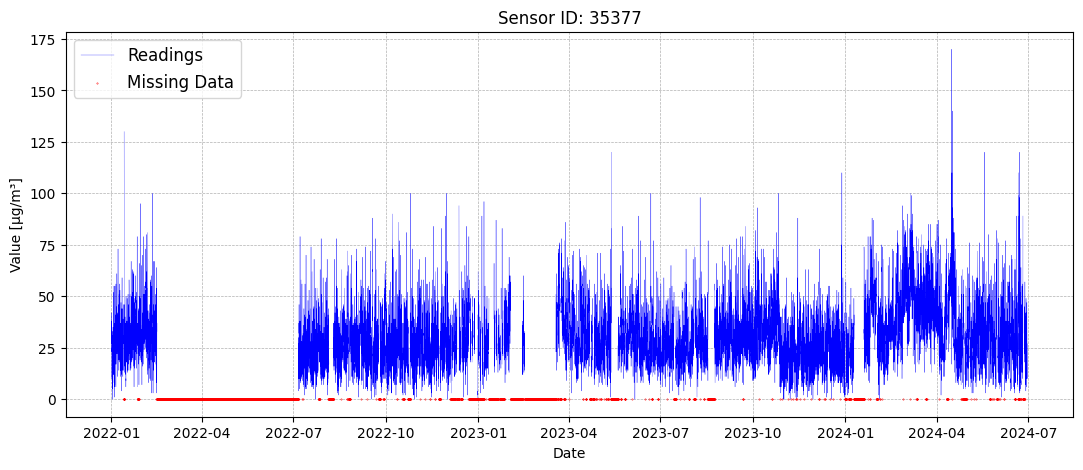

In [14]:
def plot_all_data(data, sensor_id: int, show_na=False):

    units = df_sensors[df_sensors['sensor_id'] == sensor_id]['parameter_units'].iloc[0]

    plt.figure(figsize=(13, 5))
    plt.plot(data.index, data[f"sid_{sensor_id}"], color='blue', linestyle='-', linewidth=0.2, label="Readings")
    if show_na:
        missing_data = data[data[f"sid_{sensor_id}"].isna()]
        plt.scatter(missing_data.index, [0]*len(missing_data), color='red', label='Missing Data', zorder=5, s=0.1)
    plt.title(f'Sensor ID: {sensor_id}')
    plt.xlabel('Date')
    plt.ylabel(f'Value [{units}]')
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

plot_all_data(sensor_measurements, 35377, show_na=True)

### Inspecting NA density per sensor

In [15]:
sensor_measurements.isna().mean().sort_values(ascending=False)

sid_5079565    0.595655
sid_5079414    0.566385
sid_35624      0.377727
sid_34835      0.339218
sid_36064      0.325543
sid_36092      0.323622
sid_35578      0.320878
sid_34997      0.319918
sid_20466      0.316579
sid_20468      0.313195
sid_34845      0.312600
sid_35609      0.307798
sid_34834      0.306472
sid_36047      0.305603
sid_35380      0.304276
sid_34841      0.301898
sid_35577      0.299566
sid_35606      0.295769
sid_20476      0.294626
sid_36009      0.293574
sid_36066      0.293574
sid_34836      0.289504
sid_35607      0.288909
sid_35377      0.286805
sid_35843      0.282003
sid_35394      0.265996
dtype: float64

To better understand the distribution of missing data across the dataset, we use a heatmap.

  - The heatmap uses a color map (`cmap='hot'`) to highlight missing data points.
  - Each row represents a timestamp, and each column corresponds to a sensor.

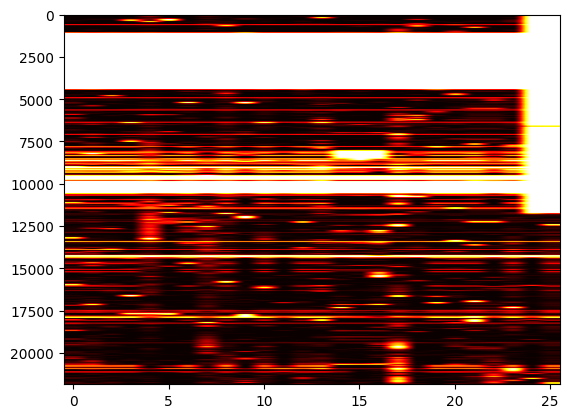

In [16]:
plt.imshow(sensor_measurements.isnull(), cmap='hot', aspect='auto')
plt.show()

### Proportion of Fully Missing Rows

As you can see from the heatmap, there are some periods in time for which we do not have any measurement at all. We now calculate the proportion of rows with all sensor measurements missing and then proceed to remove these rows from our dataset:

In [17]:
print(f"{sum(sensor_measurements.isna().all(axis=1))/len(sensor_measurements)*100:.3f}% of the data contains no measurements.")

23.837% of the data contains no measurements.


In [18]:
sensor_measurements.dropna(how='all',inplace=True)

Now we calculate the mean of missing values (`isna().mean()`) for each sensor. Sensors with more than 15% missing data are flagged for removal.

For each sensor to be removed, we retrieve the corresponding sensor and location IDs from the `df_sensors` DataFrame.

In [19]:
na_mask = sensor_measurements.isna().mean() > 0.15
sensors_to_remove = sensor_measurements.isna().mean()[na_mask].keys()

lids = []
sids = []
for sid in sensors_to_remove:
    lid = df_sensors[df_sensors['sensor_id'] == int(sid.split("_")[1])]["location_id"].iloc[0]
    sids.append(int(sid.split("_")[1]))
    lids.append(lid)

After identifying sensors with high missing data, we further check which locations still have some sensors with sufficient data:

- **Filtering Locations**:
  - We filter the `df_sensors` DataFrame to find locations (`location_id`) that are in the list of `lids` (locations with sensors to remove) but still have other sensors (`sensor_id`) not flagged for removal.

In [20]:
locs_with_some_sensonrs = df_sensors[(df_sensors['location_id'].isin(lids)) & ~(df_sensors['sensor_id'].isin(sids))]['location_id'].values.tolist()

In [21]:
affected_locations = list(filter(lambda x: x not in locs_with_some_sensonrs, lids))

### Visualizing Affected Locations

In this step, we update our interactive map to highlight locations based on the status of their sensors:

   - **Red Circles**: Locations where all sensors are flagged for removal are marked with red circles, indicating complete data loss at these locations.
   - **Yellow Circles**: Locations that still have some sensors with sufficient data, despite some sensors being flagged, are marked with yellow circles.



In [22]:
map = folium.Map(location=mde_center, zoom_start=zoom_level)

for idx, row in df_locations.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=f"ID: {row['id']}").add_to(map)
    if row['id'] in affected_locations:

        circle = folium.Circle(
            location=[row['latitude'], row['longitude']],
            radius=500,
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(map)

    elif row['id'] in locs_with_some_sensonrs:

        circle = folium.Circle(
            location=[row['latitude'], row['longitude']],
            radius=500,
            color='yellow',
            fill=True,
            fill_color='yellow'
        ).add_to(map)

map.save('./img/maps/affected_locations.html')

map

![](./img/affected_locations.png)

Now we update our data and also our locations and sensors dataframes:

In [23]:
sensor_measurements.drop(sensors_to_remove, axis=1, inplace=True)

In [24]:
updated_sensors = df_sensors[~df_sensors['sensor_id'].isin(sids)]
updated_sensors.reset_index(inplace=True, drop=True)

In [25]:
updated_locations = df_locations[~df_locations['id'].isin(list(set(affected_locations)))]
updated_locations.reset_index(inplace=True, drop=True)

## Selecting a Candidate Sensor for Replacement

In this section, we aim to identify a candidate sensor to replace with a machine learning model. Our first criterion is to select a sensor with the highest proportion of missing data after filtering. This approach prioritizes replacing sensors that provide the least reliable data.

1. **Identifying Top Sensors with Missing Data**:
   - We sort the sensors by the proportion of missing data in descending order.
   - The top three sensors with the most missing data are selected.

2. **Determining Corresponding Locations**:
   - We retrieve the `location_id` for each of these sensors, identifying the specific locations affected.


In [26]:
lids = []
for top_3_na_sensor in list(sensor_measurements.isna().mean().sort_values(ascending=False).keys()[:3]):
    lids.append(df_sensors[df_sensors['sensor_id'] == int(top_3_na_sensor.split("_")[1])]["location_id"].iloc[0])

### Identifying Nearby Locations for Selected Sensors

To support the machine learning model in predicting sensor readings, we identify nearby sensors that can provide contextual data:

1. **Function `find_nearby_locations`**:
   - This function calculates distances between a given location and other locations within a specified radius.
   - It uses the [Haversine formula](https://en.wikipedia.org/wiki/Haversine_formula) to compute distances in kilometers.
   - Locations are filtered to include only those within the specified radius and are optionally sorted by distance.

2. **Applying the Function**:
   - We apply this function to each of the selected locations (`lids`), storing the nearby locations in the `sensor_and_nearby` dictionary.

In [27]:
def find_nearby_locations(location_id, df, radius, sort=False):
    location = df[df['id'] == location_id].iloc[0]
    location_coords = (location['latitude'], location['longitude'])
    
    # Calculate distances and filter
    nearby_locations = []
    for _, row in df.iterrows():
        target_coords = (row['latitude'], row['longitude'])
        distance = haversine(location_coords, target_coords, unit=Unit.KILOMETERS)
        if distance <= radius and row['id'] != location_id:
            nearby_locations.append((row['id'], distance))
    
    # Sort by distance if requested
    if sort:
        nearby_locations.sort(key=lambda x: x[1])
    
    # Extract the sorted IDs
    nearby_ids = [loc[0] for loc in nearby_locations]
    
    return nearby_ids

sensor_and_nearby = {}
for loc_id in lids:
    sensor_and_nearby[loc_id] = find_nearby_locations(loc_id, updated_locations, radius=7, sort=False)

These are the sensors that are within a 7km radius of the selected sensors:

In [28]:
sensor_and_nearby

{10500: [10503, 10547, 10681, 10778],
 10797: [7061, 7063, 10643, 10689, 10746, 10793, 10805],
 10805: [7061, 10503, 10643, 10681, 10682, 10689, 10746, 10793, 10797]}

Now let's visualize them:

In [29]:
map = folium.Map(location=mde_center, zoom_start=zoom_level)

# Add points to the map with popups showing the ID
for idx, row in updated_locations.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=f"ID: {row['id']}").add_to(map)
    if row['id'] in lids:

        circle = folium.Circle(
            location=[row['latitude'], row['longitude']],
            radius=7000,
            color='green',
            fill=True,
            fill_color='green',
            tooltip=f"Included locations: {sensor_and_nearby[row['id']]}"
        ).add_to(map)

map.save('./img/maps/na_sensors_and_closest.html')

map

![](./img/na_sensors_and_closest.png)

The image above shows the selected candidate locations and their surrounding areas marked by circles. These locations are not optimal because they do not cover many locations with sensors, and there are numerous locations nearby, potentially leading to redundant data collection.

To address this, we will visually inspect different locations to identify a more suitable candidate for our machine learning model replacement, aiming for better coverage and minimal redundancy.

## Selected location: 10689

After visually inspecting various locations, we chose the location depicted in the image below. This location offers several improvements:

- Coverage: It covers a broader area with fewer sensors, which means the machine learning model can potentially have a more significant impact by filling in gaps where fewer measurements are available.
- Sensor Density: There is a more balanced distribution of sensors around the area, reducing redundancy and ensuring that the model will not be overly dependent on data from nearby sensors.

In [30]:
lid_10689_nearby = find_nearby_locations(10689, updated_locations, radius=7)

map = folium.Map(location=mde_center, zoom_start=zoom_level)
for idx, row in updated_locations.iterrows():
    folium.Marker([row['latitude'], row['longitude']], popup=f"ID: {row['id']}").add_to(map)
    if row['id'] == 10689:

        circle = folium.Circle(
            location=[row['latitude'], row['longitude']],
            radius=7000,
            color='green',
            fill=True,
            fill_color='green',
            tooltip=f"Included locations: {lid_10689_nearby}"
        ).add_to(map)

map.save('./img/maps/location_10689.html')

map

![](./img/location_10689.png)

In [31]:
lid_10689_nearby

[7061, 10503, 10643, 10681, 10746, 10793, 10797, 10805]

In [32]:
x_selected_sensors = updated_sensors[updated_sensors['location_id'].isin(lid_10689_nearby)]
y_selected_sensors = updated_sensors[updated_sensors['location_id'].isin([10689])]

In [33]:
x_selected_sensors

,location_id,sensor_id,sensor_name,parameter_id,parameter_name,parameter_units,parameter_displayName
0,7061,20466,pm25 µg/m³,2,pm25,µg/m³,PM2.5
6,10503,34845,no2 ppm,7,no2,ppm,NO₂
7,10503,34841,pm25 µg/m³,2,pm25,µg/m³,PM2.5
11,10643,35394,o3 ppm,10,o3,ppm,O₃
12,10681,35577,pm25 µg/m³,2,pm25,µg/m³,PM2.5
17,10746,35843,pm10 µg/m³,1,pm10,µg/m³,PM10
19,10793,36047,pm25 µg/m³,2,pm25,µg/m³,PM2.5
20,10797,36066,pm10 µg/m³,1,pm10,µg/m³,PM10
21,10797,36064,pm25 µg/m³,2,pm25,µg/m³,PM2.5
22,10805,36092,pm25 µg/m³,2,pm25,µg/m³,PM2.5


In [34]:
y_selected_sensors

,location_id,sensor_id,sensor_name,parameter_id,parameter_name,parameter_units,parameter_displayName
14,10689,35609,co ppm,8,co,ppm,CO
15,10689,35607,no2 ppm,7,no2,ppm,NO₂
16,10689,35606,pm10 µg/m³,1,pm10,µg/m³,PM10


### Parameters Monitored at Selected Location

The table below lists the types of particles and gaseous pollutants measured by sensors [supported by OpenAQ](https://docs.openaq.org/docs/parameters), along with their presence at the selected location:

| Parameter         | Description                                    | Unit          | Present at Location |
|-------------------|------------------------------------------------|---------------|---------------------|
| PM2.5             | Particulate matter smaller than 2.5 microns    | µg/m³, particles/cm³ | ❌                  |
| PM4               | Particulate matter smaller than 4 microns      | µg/m³, particles/cm³ | ❌                  |
| PM10              | Particulate matter smaller than 10 microns     | µg/m³, particles/cm³ | ✅                  |
| NO                | Nitrogen Monoxide                              | ppm           | ❌                  |
| NO₂               | Nitrogen Dioxide                               | ppm           | ✅                  |
| CH₄               | Methane                                        | ppm           | ❌                  |
| SO₂               | Sulfur Dioxide                                 | ppm           | ❌                  |
| O₃                | Ozone                                          | ppm           | ❌                  |
| CO                | Carbon Monoxide                                | ppm           | ✅                  |
| BC                | Black Carbon                                   |                | ❌                  |

In [35]:
x_selected_sensors_ids = x_selected_sensors['sensor_id'].values.tolist()
x_colnames = ["sid_" + str(id) for id in x_selected_sensors_ids]
y_selected_sensors_ids = y_selected_sensors['sensor_id'].values.tolist()
y_colnames = ["sid_" + str(id) for id in y_selected_sensors_ids]

### Preparing the Dataset for Modeling

To prepare for machine learning modeling, we construct a dataset that includes both input features (`x_colnames`) and target variables (`y_colnames`).

We also drop rows that contain any missing values in the target variables (`y_colnames`).

In [36]:
dataset = sensor_measurements[x_colnames + y_colnames].copy()
dataset.dropna(subset=y_colnames,how='any', inplace=True)
dataset

,sid_20466,sid_34845,sid_34841,sid_35394,sid_35577,sid_35843,sid_36047,sid_36066,sid_36064,sid_36092,sid_35609,sid_35607,sid_35606
2022-01-01 00:00:00+00:00,9.9,0.016,20.0,0.0100,15.0,41.0,14.0,41.0,19.0,21.0,0.86,0.018,26.0
2022-01-01 01:00:00+00:00,14.0,0.014,20.0,0.0110,18.0,35.0,12.0,36.0,30.0,36.0,1.50,0.014,55.0
2022-01-01 02:00:00+00:00,25.0,0.013,23.0,0.0110,24.0,34.0,16.0,46.0,28.0,32.0,1.60,0.013,39.0
2022-01-01 03:00:00+00:00,27.0,0.011,27.0,0.0110,39.0,39.0,20.0,48.0,32.0,54.0,1.40,0.012,33.0
2022-01-01 04:00:00+00:00,26.0,0.012,27.0,0.0120,33.0,37.0,29.0,40.0,33.0,84.0,0.78,0.011,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-29 20:00:00+00:00,4.9,0.015,3.0,0.0230,23.0,NaN,1.2,39.0,36.0,NaN,1.80,0.026,14.0
2024-06-29 21:00:00+00:00,7.3,0.012,8.0,0.0100,0.5,26.0,NaN,NaN,8.0,NaN,1.80,0.030,24.0
2024-06-29 22:00:00+00:00,7.2,0.023,26.0,0.0120,NaN,34.0,23.0,NaN,NaN,12.0,2.00,0.035,43.0
2024-06-29 23:00:00+00:00,11.0,0.031,20.0,0.0054,7.1,55.0,32.0,NaN,40.0,23.0,2.50,0.038,22.0


For the remainder of this notebook, we will focus on creating a model to predict PM10 concentrations:

In [37]:
target = 'sid_35606'

### Interpolating Missing Data

To address any remaining missing values in the predictors, we apply time-based interpolation:

- **Method**: `interpolate(method='time')`
  - This method fills in missing values by interpolating based on the time index, providing estimated values that are consistent with the time series trend.
  - It is particularly useful for time series data, as it maintains the temporal continuity and smoothness of the dataset.


In [38]:
dataset.interpolate(method='time', inplace=True)

## Setting a Baseline for the ML Model

Before training our machine learning model, it's imperative to establish a baseline performance. This baseline helps us understand the minimum performance our model must achieve to be considered effective.

The baseline approach involves the following steps:

1. **Identify Closest Sensors**:
   - We identify the three closest sensors to our selected location.

2. **Calculate Average of Nearby Sensors**:
   - For each time point, we compute the mean value of the readings from these three sensors.

3. **Calculate Baseline RMSE**:
   - We then calculate the Root Mean Square Error (RMSE) between these averaged readings and the actual readings (truth data) from the sensor we are looking to replace.

This baseline RMSE provides a benchmark against which we can compare our ML model's performance. The model needs to achieve a lower RMSE than this baseline to be considered a better alternative to simply averaging data from nearby sensors.

In [39]:
nearby_10689 = find_nearby_locations(10689, updated_locations, radius=7, sort=True)
updated_sensors[updated_sensors.location_id.isin(nearby_10689)]

,location_id,sensor_id,sensor_name,parameter_id,parameter_name,parameter_units,parameter_displayName
0,7061,20466,pm25 µg/m³,2,pm25,µg/m³,PM2.5
6,10503,34845,no2 ppm,7,no2,ppm,NO₂
7,10503,34841,pm25 µg/m³,2,pm25,µg/m³,PM2.5
11,10643,35394,o3 ppm,10,o3,ppm,O₃
12,10681,35577,pm25 µg/m³,2,pm25,µg/m³,PM2.5
17,10746,35843,pm10 µg/m³,1,pm10,µg/m³,PM10
19,10793,36047,pm25 µg/m³,2,pm25,µg/m³,PM2.5
20,10797,36066,pm10 µg/m³,1,pm10,µg/m³,PM10
21,10797,36064,pm25 µg/m³,2,pm25,µg/m³,PM2.5
22,10805,36092,pm25 µg/m³,2,pm25,µg/m³,PM2.5


In [40]:
updated_sensors[updated_sensors['location_id'].isin([10689] + nearby_10689[:3]) & (updated_sensors['parameter_units'] == "µg/m³")]

,location_id,sensor_id,sensor_name,parameter_id,parameter_name,parameter_units,parameter_displayName
0,7061,20466,pm25 µg/m³,2,pm25,µg/m³,PM2.5
7,10503,34841,pm25 µg/m³,2,pm25,µg/m³,PM2.5
16,10689,35606,pm10 µg/m³,1,pm10,µg/m³,PM10
22,10805,36092,pm25 µg/m³,2,pm25,µg/m³,PM2.5


We will use the readings from these sensors to estimate the PM10 values for our target sensor. However, we expect a substantial difference because PM2.5 is a subset of PM10 measurements. Therefore, the mean PM2.5 readings from the other sensors are likely to underestimate the PM10 values from our target sensor.

In [41]:
print(f"Baseline (mean of PM2.5 sensors): ± {root_mean_squared_error(dataset[["sid_20466", "sid_34841", "sid_36092"]].mean(axis=1), dataset["sid_35606"]):.3f} µg/m³")

Baseline (mean of PM2.5 sensors): ± 19.669 µg/m³


Notice that there is a sensor in the vicinity with PM10 readings: 35843. Let's see what happens if we take this as the replacement measurement for our target:

In [42]:
print(f"Baseline (use Sensor #35843's measurements): ± {root_mean_squared_error(dataset[["sid_35843"]], dataset["sid_35606"]):.3f} µg/m³")

Baseline (use Sensor #35843's measurements): ± 20.948 µg/m³


## Data Preparation

Let's visualize the sensor # 35606 data. Note that there are some measurements that are very high and is very likely to be bad readings:

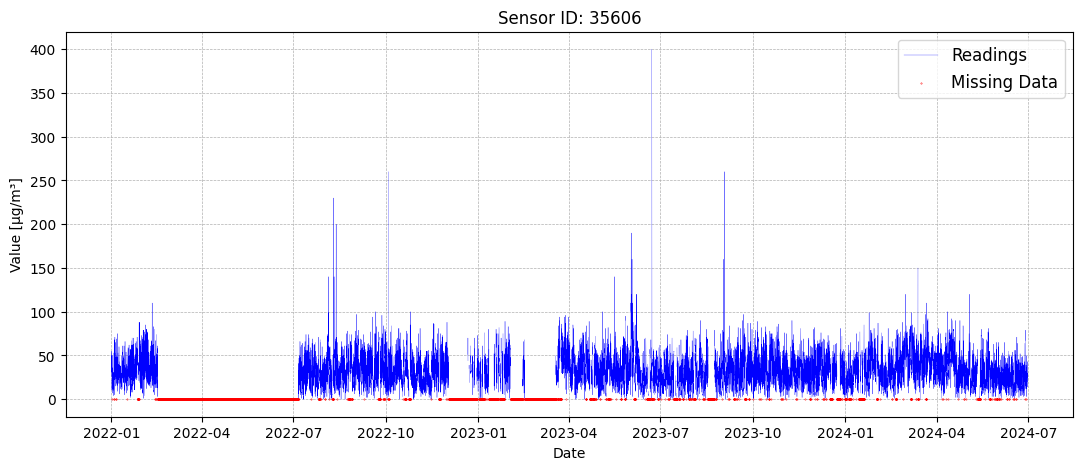

In [43]:
# This is how we built `sensor_measurements` originally, without filtering data
complete_sensor_measurements = pivot_df.reindex(date_range)
plot_all_data(complete_sensor_measurements, 35606, show_na=True)

### Outlier Detection and Removal

To ensure the quality of our data, we identify and remove outliers from the dataset using the Z-score:

$$ Z = \frac{X - \mu}{\sigma} $$

where:

- $Z$ is the Z-score,
- $X$ is the value in the dataset,
- $\mu$ is the mean of the dataset,
- $\sigma$ is the standard deviation of the dataset.

After calculating the Z-score, we determine a threshold of 3 standard deviations. This means that data points with an absolute Z-score greater than or equal to 3 are considered outliers and will be excluded from the dataset.

In [44]:
threshold = 3
z_scores = stats.zscore(complete_sensor_measurements['sid_35606'], nan_policy="omit")

outliers = complete_sensor_measurements[target][(np.abs(z_scores) >= threshold) | complete_sensor_measurements[target].isna()]
data_cleaned = complete_sensor_measurements[target][(np.abs(z_scores) < threshold) | complete_sensor_measurements[target].isna()]


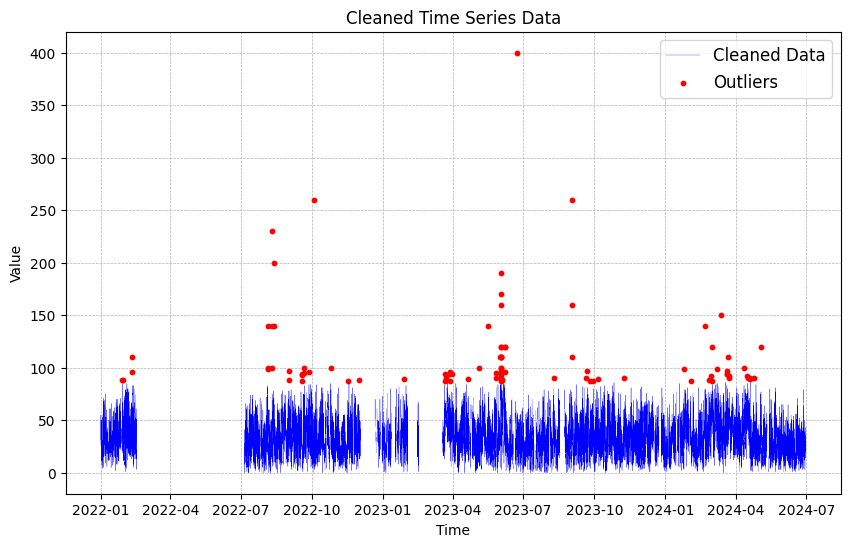

In [45]:
plt.figure(figsize=(10, 6))

# Plotting the cleaned data
plt.plot(data_cleaned.index, data_cleaned.values, color='blue', linestyle='-', linewidth=0.2, label='Cleaned Data')

# Plotting the outliers
plt.scatter(outliers.index, outliers.values, color='red', label='Outliers', zorder=5, s=10)

plt.title('Cleaned Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')

plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


We remove outliers from the dataset by calculating Z-scores for each feature and applying a threshold (e.g., ±3) to identify extreme values. A combined mask flags rows with at least one outlier, which are then removed. This cleaning step ensures the data is free from extreme values that could negatively impact analysis and model performance.

In [46]:
z_scores = dataset.apply(stats.zscore)

masks = []
for col in dataset.columns:
    masks.append(abs(z_scores[col]) > threshold)

mask = reduce(lambda x, y: x | y, masks)

In [47]:
dataset_cleaned = dataset.copy()

dataset_cleaned = dataset_cleaned[~mask]

In [48]:
print(f"Original dataset (nrows): {len(dataset)}\nCleaned dataset (nrows): {len(data_cleaned)}")

Original dataset (nrows): 14483
Cleaned dataset (nrows): 21775


## Modeling

### Training an XGBoost

To train our machine learning model, we use XGBoost, a powerful gradient boosting algorithm. The dataset is split into training and testing sets to evaluate the model's performance.

1. **Data Preparation**:
   - `X` represents the input features, and `y` is the target variable.
   - The data is split into `train_x` and `valid_x` for training and validation, respectively, with a test size of 20%. We do not shuffle the data to preserve older data as part of the training set.

2. **Model Optimization with Optuna**:
   - The `objective` function defines the model training process using Optuna for hyperparameter tuning.
   - Several parameters are tuned, including the booster type, regularization weights (`lambda`, `alpha`), subsampling ratios (`subsample`, `colsample_bytree`), and other booster-specific parameters.
   - For `gbtree` and `dart` boosters, additional parameters like `eta`, `max_depth`, `min_child_weight`, `gamma`, and `grow_policy` are also optimized.
   - If using the `dart` booster, `sample_type`, `normalize_type`, `rate_drop`, and `skip_drop` are considered.

3. **Model Evaluation**:
   - The model's performance is evaluated using the Root Mean Squared Error (RMSE) between the predicted and actual values in the validation set.

In [49]:
X = dataset_cleaned[x_colnames]
y = dataset_cleaned[target]

# Split the data into training and testing sets
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, shuffle=False)

dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

def objective(trial):

    param = {
        "verbosity": 0,
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # XGBoost will perform validation of input parameters to check whether a parameter is used or not.
        "validate_parameters": True,

        "objective": "reg:squarederror",
        "tree_method": "auto",
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    param["n_estimators"] = trial.suggest_int("n_estimators", 100, 300)

    if param["booster"] in ["gbtree", "dart"]:
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    mse = root_mean_squared_error(valid_y, preds)
    return mse


In [50]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000, timeout=600)

print("Best trial:")
trial = study.best_trial

print(f"  RMSE: {trial.value:.4f}")
print("  Parameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  RMSE: 10.5759
  Parameters: 
    booster: dart
    lambda: 0.003395995074399337
    alpha: 0.0025723775342832715
    subsample: 0.9460207390941472
    colsample_bytree: 0.8697219684493142
    max_depth: 7
    n_estimators: 237
    eta: 0.17481989388014174
    min_child_weight: 9
    gamma: 0.0005308681289824652
    grow_policy: lossguide
    sample_type: weighted
    normalize_type: forest
    rate_drop: 2.823295242164268e-08
    skip_drop: 2.982534968237973e-08


### Additional Experiments: Dimensionality Reduction

To further enhance our model, we explore two approaches for dimensionality reduction: feature selection and Principal Component Analysis (PCA).

#### Feature Selection

1. **Closest Sensors**:
   - We select data from the sensors closest to our target sensor. The intuition is that nearby sensors may provide the most relevant data for predicting the target sensor's measurements.
   - This approach reduces the number of features by focusing on those sensors that are geographically closest to the target.

2. **Model Fitting**:
   - We fit models using only the selected features to see if this targeted approach improves prediction accuracy.

In [51]:
X = dataset_cleaned[["sid_20466", "sid_34841", "sid_36092"]]
y = dataset_cleaned['sid_35606']

# Split the data into training and testing sets
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, shuffle=False)

dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000, timeout=600)

print("Best trial:")
trial = study.best_trial

print(f"  RMSE: {trial.value:.4f}")
print("  Parameters: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  RMSE: 11.7083
  Parameters: 
    booster: gbtree
    lambda: 0.21051208025090606
    alpha: 5.0766109264312884e-08
    subsample: 0.5828069643186446
    colsample_bytree: 0.799957770810787
    max_depth: 5
    n_estimators: 224
    eta: 0.1783829154373294
    min_child_weight: 8
    gamma: 2.2414862064382885e-07
    grow_policy: depthwise


#### Principal Component Analysis (PCA)

1. **Applying PCA**:
   - PCA is applied to the entire dataset to reduce its dimensionality while retaining most of the variance.
   - We experiment with different numbers of principal components, capturing varying levels of variance in the data.

2. **Model Fitting with PCA Components**:
   - For each subset of components chosen, we fit models to evaluate their performance.
   - This helps in understanding the trade-off between the number of components and model accuracy, potentially leading to a more compact and efficient model.

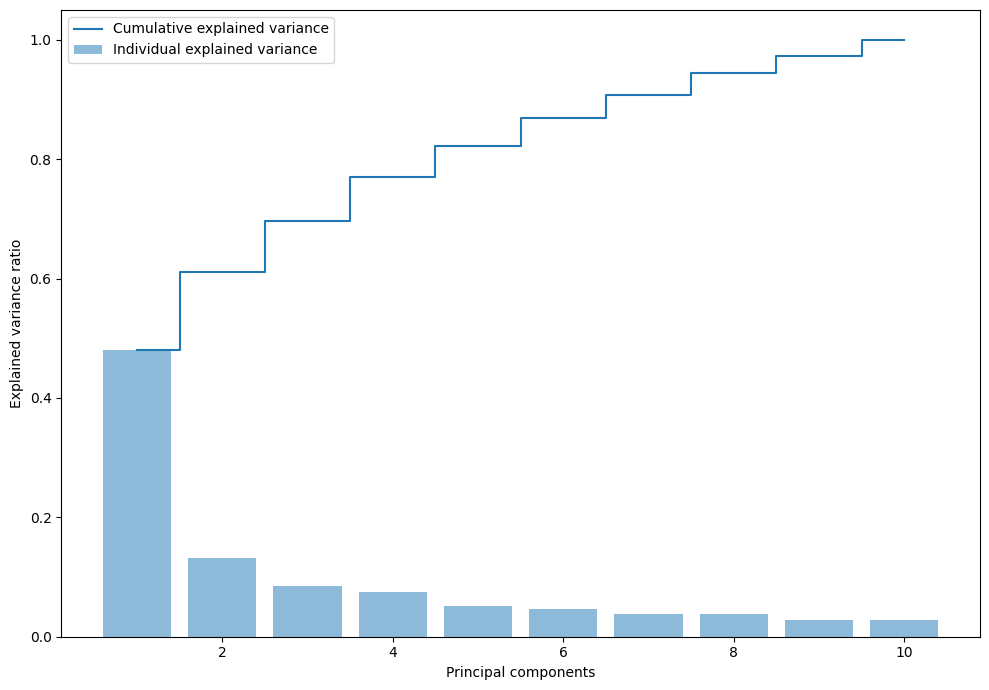

In [52]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(dataset_cleaned[x_colnames])

pca = PCA(n_components=min(dataset_cleaned[x_colnames].shape[0], dataset_cleaned[x_colnames].shape[1]))  # Number of components can't be more than min(number of samples, number of features)
principal_components = pca.fit_transform(data_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

explained_variance_df = pd.DataFrame(explained_variance_ratio, columns=['Explained Variance Ratio'])

plt.figure(figsize=(10, 7))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [53]:
for n_components in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
        
    pca_reduced = PCA(n_components=n_components)
    principal_components_reduced = pca_reduced.fit_transform(data_scaled)

    X_train, X_test, y_train, y_test = train_test_split(principal_components_reduced, y, test_size=0.2, shuffle=False)

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=1000, timeout=600)

    trial = study.best_trial
    print(f"{n_components} components. RMSE: {trial.value:.4f}")


2 components. RMSE: 11.7325
3 components. RMSE: 11.7010
4 components. RMSE: 11.7304
5 components. RMSE: 11.7219
6 components. RMSE: 11.7149
7 components. RMSE: 11.7205
8 components. RMSE: 11.7323
9 components. RMSE: 11.6943
10 components. RMSE: 11.7080


## Summary

In this notebook, we explored various approaches to predict air quality measurements using data from the OpenAQ platform. Our main goal was to replace a specific sensor in Medellin with a machine learning model. Here's a summary of the results:

1. **Baseline RMSE**:
   - The baseline RMSE, calculated by averaging the closest sensors' readings, was ±19.669 µg/m³ and ±20.948 µg/m³. This set a benchmark for evaluating the model's performance.

2. **All Features**:
   - Using all available features, the model achieved an RMSE of 10.5759, indicating a substantial improvement over the baseline.

3. **Feature Selection**:
   - By selecting data from the closest sensors, the RMSE was 11.7083. While slightly higher than using all features, this approach still outperformed the baseline significantly.

4. **Principal Component Analysis (PCA)**:
   - We experimented with PCA for dimensionality reduction, testing models with 2 to 10 components. The RMSE ranged from 11.7325 (2 components) to 11.6943 (9 components).
   - Although PCA didn't outperform the all-features model, it provided comparable results with reduced complexity.

**Conclusion**:
The model using all features yielded the best performance with an RMSE of 10.5759. This result, significantly better than the baseline RMSE, demonstrates that the machine learning model is a viable alternative to simply averaging data from nearby sensors. While feature selection and PCA approaches showed promising results, they did not surpass the model with all features. Overall, the findings suggest that the model can effectively predict sensor measurements, providing a robust solution for sensor replacement or backup scenarios.

## Next Steps

The next phase of this project involves operationalizing our machine learning model and setting up a robust infrastructure for ongoing data ingestion, model training, and deployment. The planned steps include:

1. **Orchestrating Data Ingestion and Model Training**:
   - We will use [MAGE](https://www.mage.ai/) to automate and manage the data ingestion and model training processes. This orchestration tool will help streamline workflows and ensure consistency in data handling and model updates.

2. **Experiment Tracking and Model Management**:
   - [MLflow](https://mlflow.org/) will be employed to track experiments, including hyperparameter tuning and model performance metrics. MLflow will also be used to register and manage different versions of our models, making it easier to deploy the best-performing model.

3. **API Development**:
   - We will develop an API to serve our model predictions. This API will allow for real-time predictions, providing an interface for other applications to access the model's output.

4. **Monitoring with EvidentlyAI**:
   - To ensure the ongoing performance and reliability of our model, we will implement monitoring using [EvidentlyAI](https://www.evidentlyai.com/). This tool will help us track the model's predictions over time, detect any drift in data distributions, and alert us to potential issues in model accuracy.